# Autoencoder Using CNN

## Preparations
### Load libraries

In [1]:
import numpy as np 
import pandas as pd
import pickle

import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import Conv2D, Flatten, Input, MaxPool2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras import regularizers

2025-09-14 23:02:46.631939: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-14 23:02:46.631979: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-14 23:02:46.633273: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-14 23:02:46.639632: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-14 23:02:47.385905: W tensorflow/compiler/tf2

In [3]:
import tensorflow as tf
tf.random.set_seed(143)
np.random.seed(123)

In [4]:
# Using 10 epochs will make this notebook run rather quickly.
# If you have time and are willing to wait a bit longer for better results, increase this value to e.g., 50.
nEpochs = 10

### Prepare data

In [5]:
# Load data:
mnist = tf.keras.datasets.mnist
(train_val_images, train_val_labels), (test_images, test_labels) = mnist.load_data()

# Scale image data:
train_val_images = train_val_images / 255.0
test_images = test_images / 255.0

# Split into training / validation
train_images, val_images, train_labels, val_labels = train_test_split(train_val_images, train_val_labels,
                                                                      test_size=0.20, random_state=42)

In [6]:
train_val_label_df = pd.DataFrame(train_val_labels)
train_val_label_df.columns = ['label']
train_val_label_df['label'].value_counts()

label
1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421
Name: count, dtype: int64

In [7]:
val_label_df = pd.DataFrame(val_labels)
val_label_df.columns = ['label']
val_label_df['label'].value_counts(sort=False, ascending=True)

label
7    1299
3    1219
8    1160
9    1194
5    1104
4    1176
2    1174
6    1177
1    1322
0    1175
Name: count, dtype: int64

## The autoencoder
Every autoencoder consists of two parts: an encoder and a decoder.

* The **encoder** receives the original data (in our case, the black and white images) as input and generates a lower-dimensional code from it.
* The **decoder** receives the code and decodes it into original data (e.g. the images) in the same format as the encoder's inputs.

### Model definition

The two parts put together form the autoencoder:

**Comments on activation functions:**

***Why ReLU?***

* Simplicity and Efficiency: ReLU (Rectified Linear Unit) is computationally efficient because it involves simple thresholding at zero. This makes it faster to compute compared to other activation functions.
* Sparse Activation: ReLU promotes sparsity in the network by setting negative values to zero, which can help in learning more robust features.
* Gradient Propagation: ReLU helps mitigate the vanishing gradient problem, allowing gradients to propagate more effectively during backpropagation.

***Sigmoid*** at the end to get an output between 0 and 1.

In [8]:
CNNmnist_encoder = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (28, 28, 1)),
    tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 14 × 14 x 16
    tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 7 × 7 x 32
    tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu")
])

CNNmnist_decoder = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (7, 7, 64)),
    tf.keras.layers.Conv2D(32, kernel_size = (3,3), activation = 'selu', padding = 'same'),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2D(16, kernel_size = (3,3), activation = 'selu', padding = 'same'),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2D(1, kernel_size = (3,3), activation = 'sigmoid', padding = 'same'),
])

CNNmnist_ae = tf.keras.Sequential([CNNmnist_encoder, CNNmnist_decoder])

2025-09-14 23:02:48.529306: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18229 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 2g.20gb, pci bus id: 0001:00:00.0, compute capability: 8.0


### Training
The autoencoder uses unsupervised learning, i.e. we do not pass any predefined labels or similar. Instead, the output should be as similar as possible to the input. We use the squared error as a measure of the quality of the reconstruction.

For a start, we allow a maximum of 10 epochs to train - as with the other convolutional networks (and with deep neural networks in general), you should allow significantly more epochs for real applications.

The training takes a little longer here... With the following code you can save and reload the learned weights - just set `train_from_scratch` as needed.
Please note that only the weights, not the models themselves, are saved and loaded again. The model definition is made in the code and managed as such.

Loading the weights only works if the model definition is exactly the same.

In [9]:
# compile and fit the model
tf.random.set_seed(42) 
CNNmnist_ae.compile(loss="mse", optimizer="nadam")

In [10]:
nPatience = 50

# define paths:
encoder_weights_path_10 = './CNNmnist_encoder_10.weights.h5'
decoder_weights_path_10 = './CNNmnist_decoder_10.weights.h5'
history_path = './CNNmnist_ae.history.h5'

train_from_scratch = True
if train_from_scratch:
    history_ae = CNNmnist_ae.fit(train_images, train_images, epochs=nEpochs, validation_data=(val_images, val_images),
                                 callbacks=[EarlyStopping(monitor='val_loss', patience=nPatience,
                                                          verbose=False, restore_best_weights=True)])
    # Save the weights:
    CNNmnist_encoder.save_weights(encoder_weights_path_10)
    CNNmnist_decoder.save_weights(decoder_weights_path_10)

    # Save training history:
    with open(history_path, 'wb') as f:
        pickle.dump(history_ae, f)
else:
    # load previsously computed weights
    CNNmnist_encoder.load_weights(encoder_weights_path_10)
    CNNmnist_decoder.load_weights(decoder_weights_path_10)
    # connect
    CNNmnist_ae = tf.keras.Sequential([CNNmnist_encoder, CNNmnist_decoder])
    CNNmnist_ae.build(input_shape=(None, 28, 28, 1))

    # load history:
    with open(history_path, 'rb') as f:
        history_ae = pickle.load(f)

Epoch 1/10


2025-09-14 23:02:49.965837: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2025-09-14 23:02:50.048282: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-09-14 23:02:50.358477: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-09-14 23:02:51.365756: I external/local_xla/xla/service/service.cc:168] XLA service 0x7faa0ced9ed0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-09-14 23:02:51.365787: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100 80GB PCIe MIG 2g.20gb, Compute Capability 8.0
2025-09-14 23:02:51.374430: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1757890971.482722   24890 device

1500/1500 [==============================] - 10s 4ms/step - loss: 0.0075 - val_loss: 0.0032
Epoch 2/10
1500/1500 [==============================] - 5s 4ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 3/10
1500/1500 [==============================] - 5s 4ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 4/10
1500/1500 [==============================] - 5s 4ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 5/10
1500/1500 [==============================] - 5s 4ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 6/10
1500/1500 [==============================] - 5s 4ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 7/10
1500/1500 [==============================] - 5s 4ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 8/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 9/10
1500/1500 [==============================] - 5s 4ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 10/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0012 - val_lo

Please note that only the weights, not the models themselves, are saved and loaded again. The model definition is made in the code and managed as such.

Loading the weights only works if the model definition is exactly the same.

In [11]:
def plot_history(history):
    """
    Plot model training history.
    Args:
    - history: tensorflow history object.

    Returns:
    None
    """
    plt.plot(history['loss'], label='Training')
    plt.plot(history['val_loss'], label='Validation')
    plt.legend()
    plt.xlabel('Loss history')
    plt.ylabel('Loss')

    plt.show()

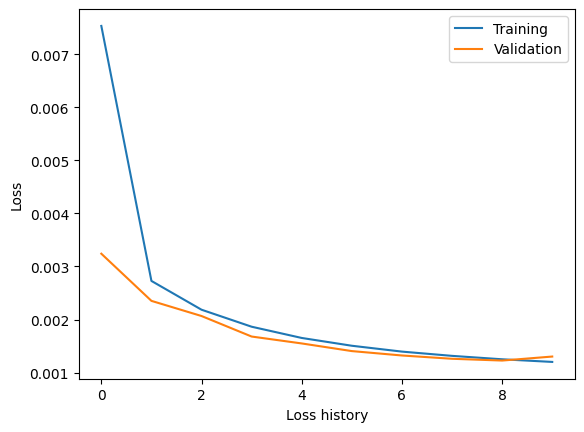

In [12]:
plot_history(history_ae.history)

### Model Summary
We compile the model and can then get a summary of the model:

In [13]:
CNNmnist_ae.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 7, 7, 64)          23296     
                                                                 
 sequential_1 (Sequential)   (None, 28, 28, 1)         23233     
                                                                 
Total params: 46529 (181.75 KB)
Trainable params: 46529 (181.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
CNNmnist_encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
Total params: 23296 (91.00 KB)
Trainable params: 23296 (

In [15]:
CNNmnist_decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 7, 7, 32)          18464     
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 16)        4624      
                                                                 
 up_sampling2d_1 (UpSamplin  (None, 28, 28, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 1)         145       
                                                                 
Total params: 23233 (90.75 KB)
Trainable params: 23233

This CNN-based model has less than a tenth of the parameters of the network without the convolution layers!

### Looking at the reconstructions
Let's look at some of the reconstructed images:

In [16]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")
    
def show_reconstructions(model, images=test_images, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])
    plt.show()

1/1 [==============================] - 0s 340ms/step


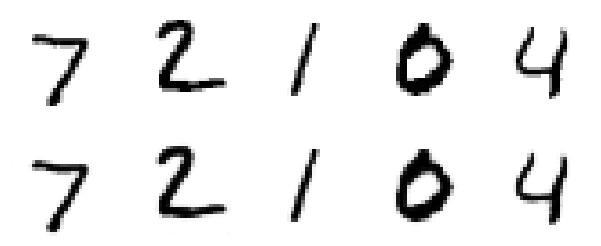

In [17]:
show_reconstructions(CNNmnist_ae)

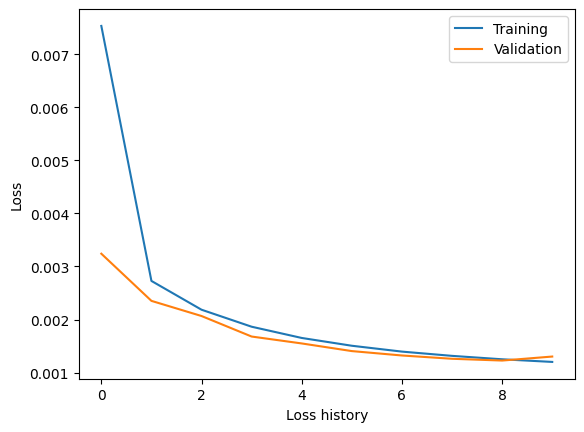

In [18]:
plot_history(history_ae.history)

## Low-dimensional bottleneck autoencoders


### Encoding Dimension 30

In [19]:
CNNmnist_encoder_30 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (28, 28, 1)),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 14 × 14 x 16
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 7 × 7 x 32
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(30, activation='relu')
])

CNNmnist_decoder_30 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(7*7*16, activation= 'relu'),
    tf.keras.layers.Reshape(target_shape = (7, 7, 16)),
    tf.keras.layers.Conv2D(32, kernel_size = (3,3), activation = 'selu', padding = 'same'),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2D(16, kernel_size = (3,3), activation = 'selu', padding = 'same'),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2D(1, kernel_size = (3,3), activation = 'sigmoid', padding = 'same'),
])

CNNmnist_ae_30 = tf.keras.Sequential([CNNmnist_encoder_30, CNNmnist_decoder_30])

In [20]:
tf.random.set_seed(42) 
CNNmnist_ae_30.compile(loss="mse", optimizer="nadam")

In [21]:
# define paths:
mnist_encoder_30_path = './CNNmnist_encoder_30.weights.h5'
mnist_decoder_30_path = './CNNmnist_decoder_30.weights.h5'
history_path = './CNNmnist_decoder_30.history.h5'

if train_from_scratch:
    history30 = CNNmnist_ae_30.fit(train_images, train_images, epochs=nEpochs, validation_data=(val_images, val_images),
                                         callbacks=[EarlyStopping(monitor='val_loss', patience=nPatience,
                                                                  verbose=False, restore_best_weights=True)])

    # Save the weights:
    CNNmnist_encoder_30.save_weights(mnist_encoder_30_path)
    CNNmnist_decoder_30.save_weights(mnist_decoder_30_path)

    # Save training history:
    with open(history_path, 'wb') as f:
        pickle.dump(history30, f)

else:
    # load previsously computed weights
    CNNmnist_encoder_30.build(input_shape=(None, 28, 28, 1))
    CNNmnist_decoder_30.build(input_shape=(None, 30))
    CNNmnist_encoder_30.load_weights(mnist_encoder_30_path)
    CNNmnist_decoder_30.load_weights(mnist_decoder_30_path)

    # load history:
    with open(history_path, 'rb') as f:
        history30 = pickle.load(f)

Epoch 1/10


2025-09-14 23:03:50.176341: I external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:326] ptxas warning : Registers are spilled to local memory in function 'fusion', 8 bytes spill stores, 8 bytes spill loads

2025-09-14 23:03:50.876506: I external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:326] ptxas warning : Registers are spilled to local memory in function 'fusion', 8 bytes spill stores, 8 bytes spill loads



1500/1500 [==============================] - 11s 5ms/step - loss: 0.0225 - val_loss: 0.0123
Epoch 2/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0108 - val_loss: 0.0096
Epoch 3/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0089 - val_loss: 0.0082
Epoch 4/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0078 - val_loss: 0.0079
Epoch 5/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0073 - val_loss: 0.0070
Epoch 6/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0069 - val_loss: 0.0071
Epoch 7/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0067 - val_loss: 0.0066
Epoch 8/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0065 - val_loss: 0.0065
Epoch 9/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0063 - val_loss: 0.0062
Epoch 10/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0061 - val_lo

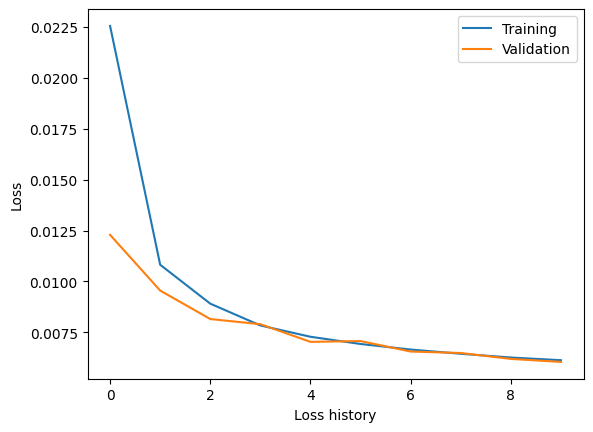

In [22]:
plot_history(history30.history)

1/1 [==============================] - 0s 242ms/step


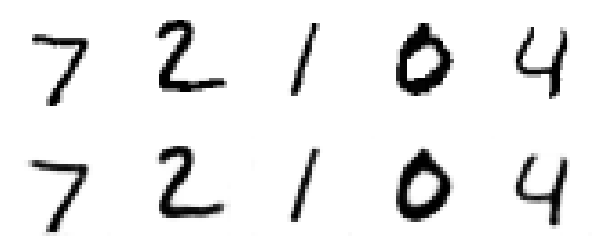

In [23]:
show_reconstructions(CNNmnist_ae_30)

In [24]:
CNNmnist_encoder_30.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 7, 7, 16)          4624      
                                                                 
 flatten (Flatten)           (None, 784)              

In [25]:
CNNmnist_decoder_30.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 100)               3100      
                                                                 
 dense_3 (Dense)             (None, 784)               79184     
                                                                 
 reshape (Reshape)           (None, 7, 7, 16)          0         
                                                                 
 conv2d_9 (Conv2D)           (None, 7, 7, 32)          4640      
                                                                 
 up_sampling2d_2 (UpSamplin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 14, 14, 16)        4624      
                                                      

### Encoding Dimension 2

**TODO**: Implement an autoencoder with an encoding dimension of 2. Follow the above example with an encoding dimension of 30.

In [26]:
# # Model definition
# # CNNmnist_encoder_2 = ...
# # 
# # CNNmnist_decoder_2 = ...
# # 
# # CNNmnist_ae_2 = ...

# tf.random.set_seed(42) 
# CNNmnist_ae_2.compile(loss="mse", optimizer="nadam")

**Solution**:

In [27]:
# Model definition
CNNmnist_encoder_2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (28, 28, 1)),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 14 × 14 x 16
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 7 × 7 x 32
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.Flatten(), # input_shape: 7 x 7 x 16
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(2)
])

CNNmnist_decoder_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(7*7*16, activation= 'relu'),
    tf.keras.layers.Reshape(target_shape = (7, 7, 16)),
    tf.keras.layers.Conv2D(8, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2D(8, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    tf.keras.layers.Conv2D(1, kernel_size = (3,3), activation = 'sigmoid', padding = 'same'),
])

CNNmnist_ae_2 = tf.keras.Sequential([CNNmnist_encoder_2, CNNmnist_decoder_2])

tf.random.set_seed(42) 
CNNmnist_ae_2.compile(loss="mse", optimizer="nadam")

**(End of Solution)**

In [28]:
# define paths:
mnist_encoder_2_path = './CNNmnist_encoder_2.weights.h5'
mnist_decoder_2_path = './CNNmnist_decoder_2.weights.h5'
history_path = './CNNmnist_decoder_2.history.h5'

if train_from_scratch:
    history2 = CNNmnist_ae_2.fit(train_images, train_images, epochs=nEpochs, validation_data=(val_images, val_images),
                                       callbacks=[EarlyStopping(monitor='val_loss', patience=nPatience,
                                                                verbose=False, restore_best_weights=True)])

    # Save the weights:
    CNNmnist_encoder_2.save_weights(mnist_encoder_2_path)
    CNNmnist_decoder_2.save_weights(mnist_decoder_2_path)

    # Save training history:
    with open(history_path, 'wb') as f:
        pickle.dump(history2, f)

else:
    # load previsously computed weights
    CNNmnist_encoder_2.build(input_shape=(None, 28, 28, 1))
    CNNmnist_decoder_2.build(input_shape=(None, 2))
    CNNmnist_encoder_2.load_weights(mnist_encoder_2_path)
    CNNmnist_decoder_2.load_weights(mnist_decoder_2_path)

    # load history:
    with open(history_path, 'rb') as f:
        history2 = pickle.load(f)

Epoch 1/10
1500/1500 [==============================] - 12s 5ms/step - loss: 0.0527 - val_loss: 0.0447
Epoch 2/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0428 - val_loss: 0.0416
Epoch 3/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0407 - val_loss: 0.0404
Epoch 4/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0397 - val_loss: 0.0394
Epoch 5/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0390 - val_loss: 0.0388
Epoch 6/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0385 - val_loss: 0.0385
Epoch 7/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0381 - val_loss: 0.0381
Epoch 8/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0378 - val_loss: 0.0378
Epoch 9/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0375 - val_loss: 0.0377
Epoch 10/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.03

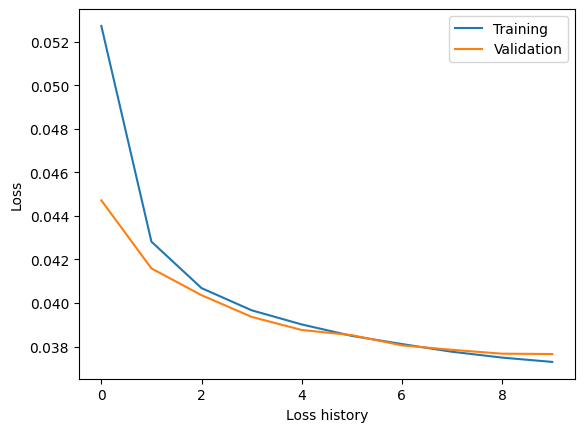

In [29]:
plot_history(history2.history)

1/1 [==============================] - 0s 347ms/step


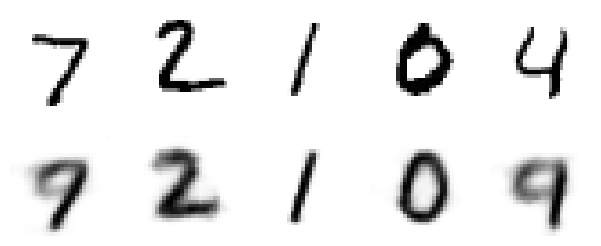

In [30]:
show_reconstructions(CNNmnist_ae_2)

### Visualizing Decodings
In the following, we will see how a few chosen codes will be decoded into an image:

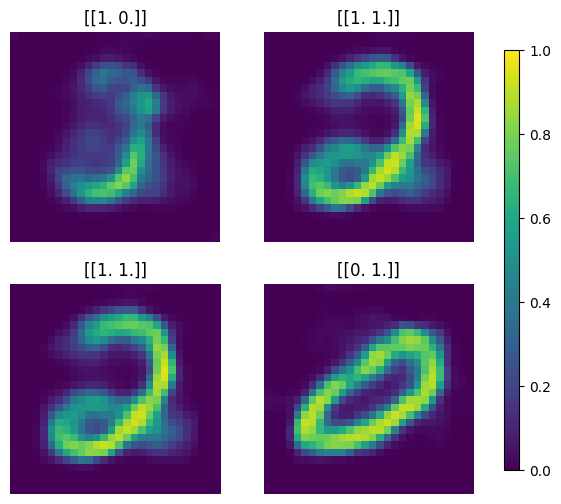

In [31]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6))

for ID1 in range(2):
    for ID2 in range(2):
        code = np.zeros(shape=[1, 2])
        code[0, ID1] = 1
        code[0, ID2] = 1
        coding = np.squeeze(CNNmnist_decoder_2(code))
        im = axs[ID1, ID2].imshow(coding, vmin=0, vmax=1)
        axs[ID1, ID2].axis('off')
        axs[ID1, ID2].set_title(code)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.025, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

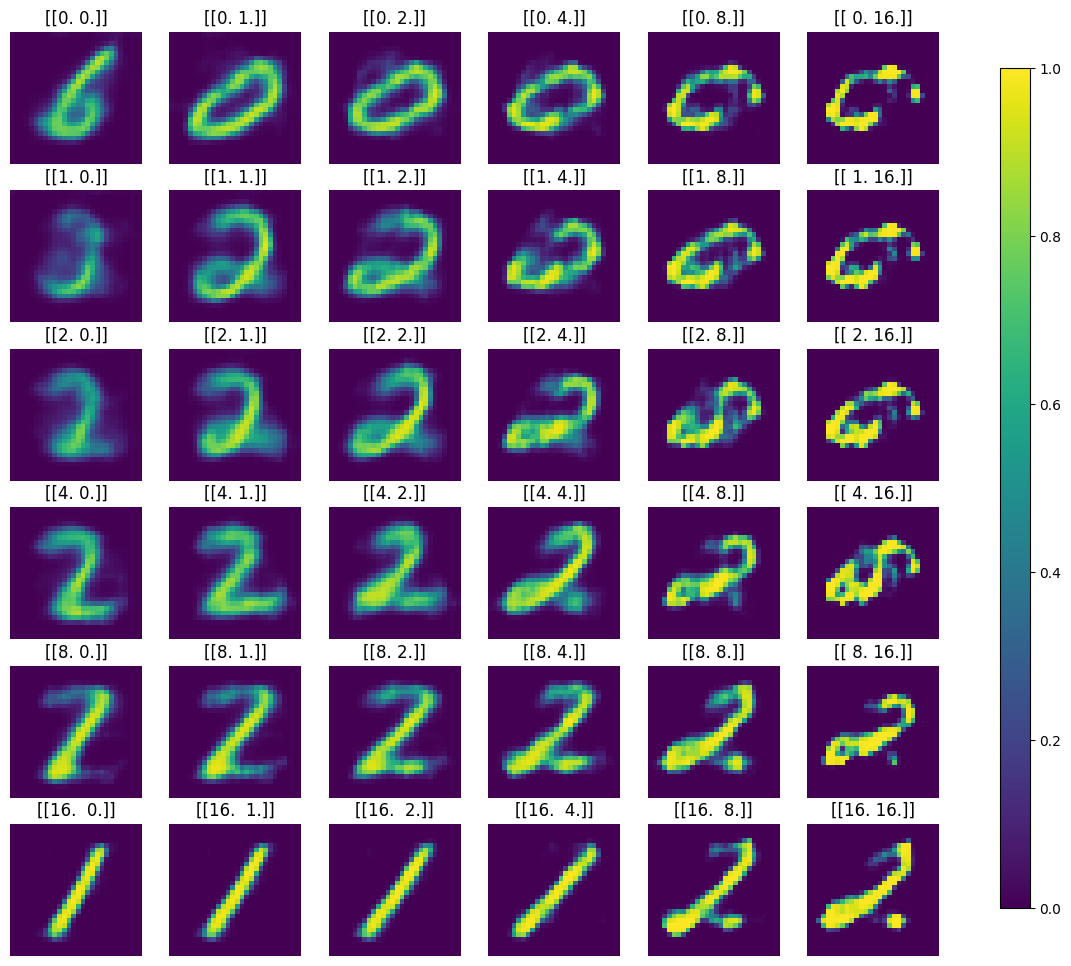

In [32]:
fig, axs = plt.subplots(6, 6, figsize=(12, 12))

for val1 in np.linspace(0, 5, 6):
    for val2 in np.linspace(0, 5, 6):
        code = np.zeros(shape=[1, 2])
        if val1>0:
            code[0, 0] = 2**(val1-1)
        if val2>0:
            code[0, 1] = 2**(val2-1)
        coding = np.squeeze(CNNmnist_decoder_2(code))
        im = axs[int(val1), int(val2)].imshow(coding, vmin=0, vmax=1)
        axs[int(val1), int(val2)].axis('off')
        axs[int(val1), int(val2)].set_title(code)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.025, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

### Visualizing Encodings
Having 2 dimensions is a very good starting points for visualization: We can look at where in the 2D code space the images representing the individual digits are projected to:

In [33]:
val_encodings2 = CNNmnist_encoder_2.predict(val_images, batch_size=256)

47/47 [==============================] - 0s 5ms/step


In [34]:
val_encodings2.shape

(12000, 2)

In [35]:
val_encodings2[:10,:]

array([[ 4.5502863e+00, -6.9050260e+00],
       [-1.0838512e-01, -1.1322695e+00],
       [ 1.2958622e+00, -1.6491213e+00],
       [ 8.7354116e+00, -8.1242161e+00],
       [ 8.1702992e-03, -6.9177467e-01],
       [ 6.6159291e+00, -8.1485939e+00],
       [ 4.8105884e+00, -5.8103576e+00],
       [ 6.2587056e+00, -7.2442575e+00],
       [ 3.3812577e-01, -2.0879099e+00],
       [ 4.9562397e+00, -9.0230436e+00]], dtype=float32)

In [36]:
sparseAE_embedding = pd.DataFrame(val_encodings2)
sparseAE_embedding.columns = ['Dimension 1', 'Dimension 2']
sparseAE_embedding['label'] = val_labels

In [37]:
sparseAE_embedding.shape

(12000, 3)

In [38]:
val_labels.shape

(12000,)

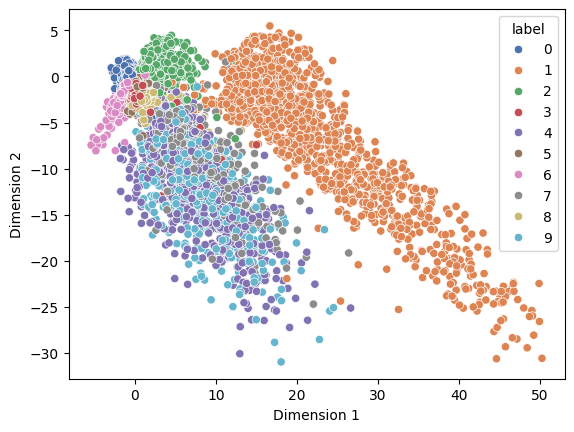

In [39]:
sns.scatterplot(sparseAE_embedding, x='Dimension 1', y='Dimension 2', hue='label', legend='full', palette='deep')
plt.show()

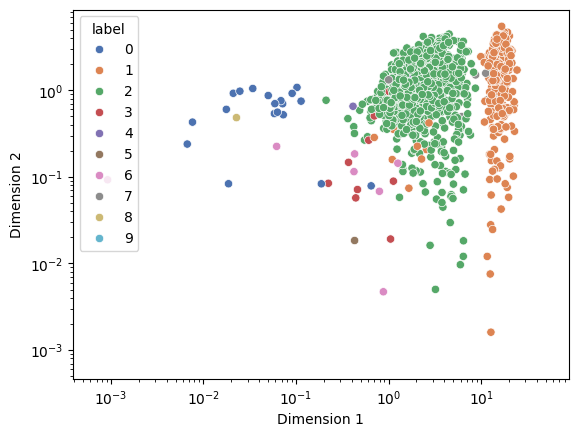

In [40]:
sns.scatterplot(sparseAE_embedding, x='Dimension 1', y='Dimension 2', hue='label', legend='full', palette='deep')
plt.xscale('log')
plt.yscale('log')
plt.show()

**TODO:** Given the above graph, can you find a code that will be decoded into an image representing the digit "0"? Use the above two plots as basis for your guess, and adapt the below code cell to verify your finding.

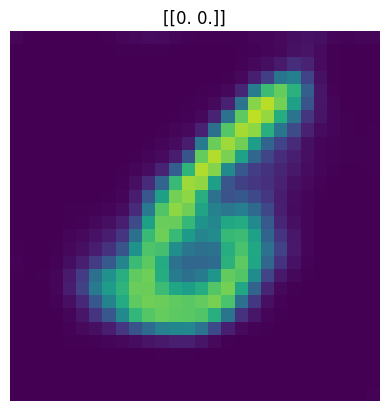

In [41]:
code = np.zeros(shape=[1, 2])
# modify the values of the first and second dimension
# code[0, 0] = ...
# code[0, 1] = ...
coding = np.squeeze(CNNmnist_decoder_2(code))
plt.imshow(coding, vmin=0, vmax=1)
plt.axis('off')
plt.title(code)
plt.show()

**Solution:**

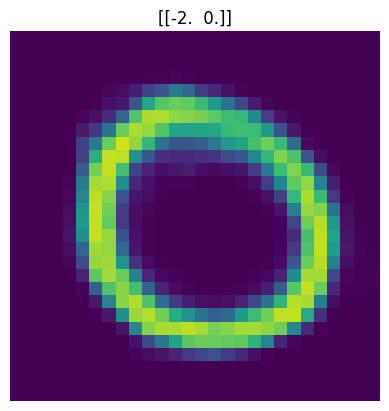

In [42]:
code = np.zeros(shape=[1, 2])
# modify the values of the first and second dimension
code[0, 0] = -2
code[0, 1] =  0
coding = np.squeeze(CNNmnist_decoder_2(code))
plt.imshow(coding, vmin=0, vmax=1)
plt.axis('off')
plt.title(code)
plt.show()

**(End of Solution)**

## Denoising with AE

In the cells below we investigate how an autoencoder can be used to denoise images. We first consider the case where the noise is additive white noise.

In [43]:
def add_noise(image_array, noise_factor=0.5, mean=0.0, std=1.0):
    """Adds Gaussian noise to each image in the supplied array."""
    noisy_array = image_array + noise_factor * np.random.normal(loc=mean, scale=std, size=image_array.shape)
    noisy_array = np.clip(noisy_array, 0., 1.)
    return noisy_array

In [44]:
from sklearn.decomposition import PCA

# Add noise:
# - to training images
train_images_noisy = add_noise(train_images)

# - to validation images
val_images_noisy = add_noise(val_images)

# - to test images
test_images_noisy = add_noise(test_images)

In [45]:
# Define Denoising Model
CNNmnist_encoder_denoise = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (28, 28, 1)),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 14 × 14 x 16
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 7 × 7 x 32
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(30, activation='relu')
])

CNNmnist_decoder_denoise = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(7*7*16, activation= 'relu'),
    tf.keras.layers.Reshape(target_shape = (7, 7, 16)),
    tf.keras.layers.Conv2D(32, kernel_size = (3,3), activation = 'selu', padding = 'same'),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2D(16, kernel_size = (3,3), activation = 'selu', padding = 'same'),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2D(1, kernel_size = (3,3), activation = 'sigmoid', padding = 'same'),
])

CNNmnist_ae_denoise = tf.keras.Sequential([CNNmnist_encoder_denoise, CNNmnist_decoder_denoise])
CNNmnist_ae_denoise.compile(loss="mse", optimizer="nadam")

In [46]:
# define paths:
CNNmnist_encoder_denoise_path = './CNNmnist_encoder_denoise.weights.h5'
CNNmnist_decoder_denoise_path = './CNNmnist_decoder_denoise.weights.h5'
history_path = './CNNmnist_decoder_denoise.history.h5'

if train_from_scratch:
    history_denoise  = CNNmnist_ae_denoise.fit(train_images_noisy, train_images, epochs=nEpochs, validation_data=(val_images_noisy, val_images),
                                               callbacks = [ EarlyStopping(monitor='val_loss', patience=nPatience,
                                                                           verbose=False, restore_best_weights=True)])
                                       
    # Save the weights:
    CNNmnist_encoder_denoise.save_weights(CNNmnist_encoder_denoise_path)
    CNNmnist_decoder_denoise.save_weights(CNNmnist_decoder_denoise_path)

    # Save training history:
    with open(history_path, 'wb') as f:
        pickle.dump(history_denoise, f)

else:
    # load previsously computed weights
    CNNmnist_encoder_denoise.load_weights(CNNmnist_encoder_denoise_path)
    CNNmnist_decoder_denoise.load_weights(CNNmnist_decoder_denoise_path)

    # load history:
    with open(history_path, 'rb') as f:
        history_denoise = pickle.load(f)

Epoch 1/10
1500/1500 [==============================] - 10s 5ms/step - loss: 0.0319 - val_loss: 0.0215
Epoch 2/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0194 - val_loss: 0.0181
Epoch 3/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0174 - val_loss: 0.0167
Epoch 4/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0162 - val_loss: 0.0161
Epoch 5/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0155 - val_loss: 0.0155
Epoch 6/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0149 - val_loss: 0.0151
Epoch 7/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0145 - val_loss: 0.0148
Epoch 8/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0143 - val_loss: 0.0146
Epoch 9/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0141 - val_loss: 0.0145
Epoch 10/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.01

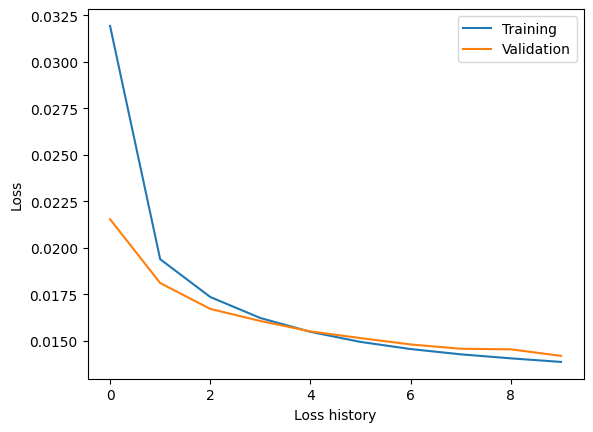

In [47]:
plot_history(history_denoise.history)

In [48]:
reconstructed_ae = CNNmnist_ae_denoise(test_images_noisy)

In [49]:
def plot_digits(X, title):
    """Small helper function to plot 100 digits."""
    fig, axs = plt.subplots(nrows=4, ncols=10, figsize=(8, 4))
    for img, ax in zip(X, axs.ravel()):
        ax.imshow(img.reshape((28, 28)), cmap="binary")
        ax.axis("off")
    fig.suptitle(title, fontsize=24)
    plt.show()

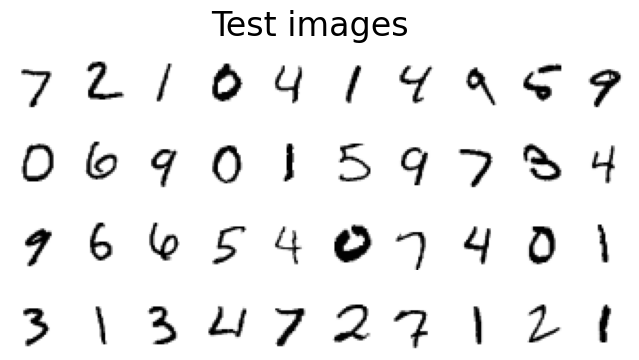

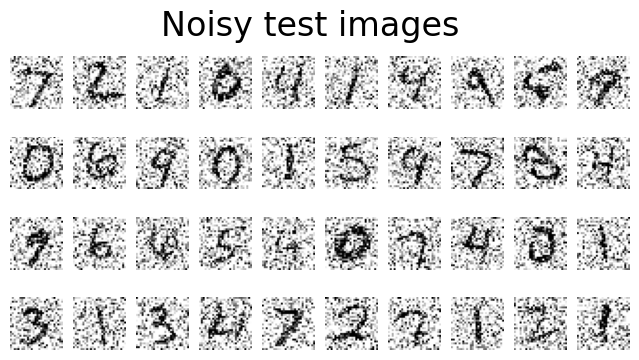

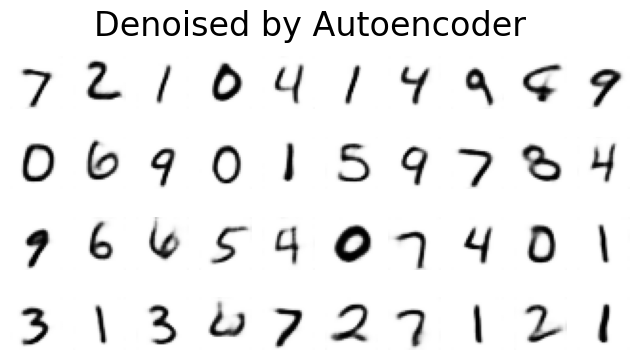

In [50]:
# Visualize the AE results
plot_digits(test_images, "Test images")
plot_digits(test_images_noisy, "Noisy test images")
plot_digits(reconstructed_ae.numpy(), "Denoised by Autoencoder")

## Denoising Masking with AE

In the cells below we investigate how an autoencoder can be used to overcome another kind of noise, namely, masking noise:

In [ ]:
def add_mask(images, mask_size):
    """Adds random masking to each image in the supplied array."""
    masked_images = images.copy()
    h, w = images.shape[1:3] # height and width of the images
    # For every image we got
    for img in masked_images: 
        top = np.random.randint(0, h - mask_size)  # Random index for the top column of the mask 
        left = np.random.randint(0, w - mask_size)  # Random index for the left column of the mask
        img[top:top+mask_size, left:left+mask_size] = 0  # Bottom and right column of mask induced based on mask_size
    return masked_images

### Masking 10x10 Pixels
As a first trial, we mask a patch of size 10 x 10 pixel, and try to reconstruct it with an autoencoder:

In [ ]:
from sklearn.decomposition import PCA

# Add masking:
# - to training images
train_images_masked_10 = add_mask(train_images, 10)

# - to validation images
val_images_masked_10 = add_mask(val_images, 10)

# - to test images
test_images_masked_10 = add_mask(test_images, 10)

In [53]:
# Define Denoising Model
CNNmnist_encoder_denoise_mask_10 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (28, 28, 1)),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 14 × 14 x 16
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 7 × 7 x 32
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(30, activation='relu')
])

CNNmnist_decoder_denoise_mask_10 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(7*7*16, activation= 'relu'),
    tf.keras.layers.Reshape(target_shape = (7, 7, 16)),
    tf.keras.layers.Conv2D(32, kernel_size = (3,3), activation = 'selu', padding = 'same'),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2D(16, kernel_size = (3,3), activation = 'selu', padding = 'same'),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2D(1, kernel_size = (3,3), activation = 'sigmoid', padding = 'same'),
])

CNNmnist_ae_denoise_mask_10 = tf.keras.Sequential([CNNmnist_encoder_denoise_mask_10, CNNmnist_decoder_denoise_mask_10])
CNNmnist_ae_denoise_mask_10.compile(loss="mse", optimizer="nadam")

In [ ]:
# Define paths:
CNNmnist_encoder_denoise_mask_10_path = './CNNmnist_encoder_denoise_mask_10.weights.h5'
CNNmnist_decoder_denoise_mask_10_path = './CNNmnist_decoder_denoise_mask_10.weights.h5'
history_path = './CNNmnist_decoder_denoise_mask_10.history.h5'

if train_from_scratch:
    history_denoise_mask_10 = CNNmnist_ae_denoise_mask_10.fit(train_images_masked_10, train_images, epochs=nEpochs, validation_data=(val_images_masked_10, val_images),
                                                         callbacks = [ EarlyStopping(monitor='val_loss', patience=nPatience,
                                                                       verbose=False, restore_best_weights=True)])

    # Save the weights:
    CNNmnist_encoder_denoise_mask_10.save_weights(CNNmnist_encoder_denoise_mask_10_path)
    CNNmnist_decoder_denoise_mask_10.save_weights(CNNmnist_decoder_denoise_mask_10_path)

    # Save training history:
    with open(history_path, 'wb') as f:
        pickle.dump(history_denoise_mask_10, f)

else:
    # Load previsously computed weights
    CNNmnist_encoder_denoise_mask_10.load_weights(CNNmnist_encoder_denoise_mask_10_path)
    CNNmnist_decoder_denoise_mask_10.load_weights(CNNmnist_decoder_denoise_mask_10_path)

    # Load history:
    with open(history_path, 'rb') as f:
        history_denoise_mask_10 = pickle.load(f)

Epoch 1/10
1500/1500 [==============================] - 10s 5ms/step - loss: 0.0309 - val_loss: 0.0212
Epoch 2/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0193 - val_loss: 0.0180
Epoch 3/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0172 - val_loss: 0.0167
Epoch 4/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0160 - val_loss: 0.0162
Epoch 5/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0153 - val_loss: 0.0158
Epoch 6/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0147 - val_loss: 0.0150
Epoch 7/10
1500/1500 [==============================] - 7s 4ms/step - loss: 0.0143 - val_loss: 0.0146
Epoch 8/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0139 - val_loss: 0.0144
Epoch 9/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0136 - val_loss: 0.0138
Epoch 10/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.01

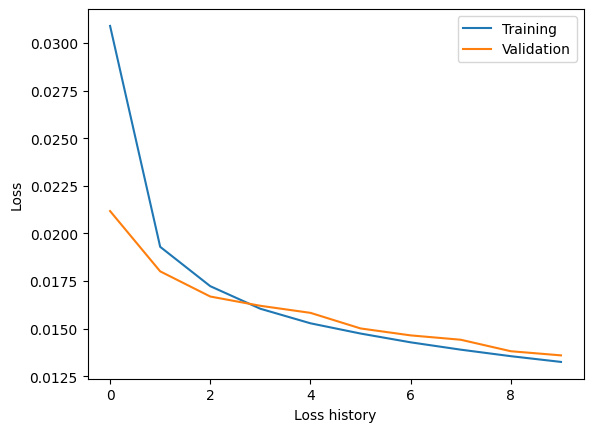

In [55]:
plot_history(history_denoise_mask_10.history)

In [56]:
reconstructed_ae_10 = CNNmnist_ae_denoise_mask_10(test_images_masked_10)

In [57]:
def plot_digits(X, title):
    """Small helper function to plot 100 digits."""
    fig, axs = plt.subplots(nrows=4, ncols=10, figsize=(8, 4))
    for img, ax in zip(X, axs.ravel()):
        ax.imshow(img.reshape((28, 28)), cmap="binary")
        ax.axis("off")
    fig.suptitle(title, fontsize=24)
    plt.show()

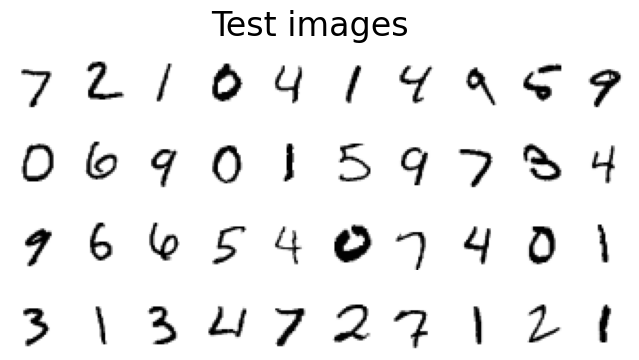

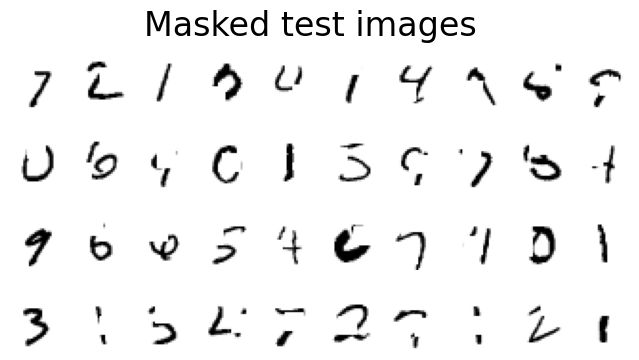

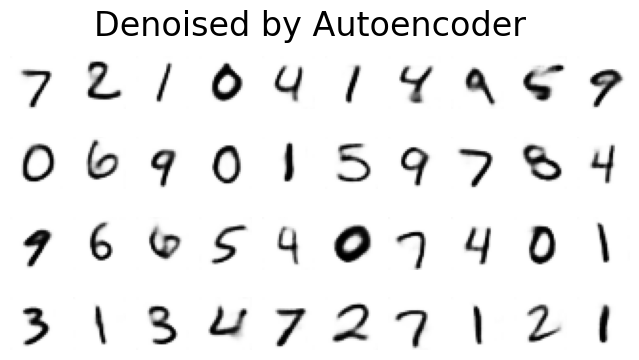

In [58]:
# Visualize the AE results
plot_digits(test_images, "Test images")
plot_digits(test_images_masked_10, "Masked test images")
plot_digits(reconstructed_ae_10.numpy(), "Denoised by Autoencoder")

### Masking 14x14 Pixels
Next we mask a patch corresponding to 1/4 of the total image pixels:

In [ ]:
from sklearn.decomposition import PCA

# Add masking:
# - to training images
train_images_masked_14 = add_mask(train_images, 14)

# - to validation images
val_images_masked_14 = add_mask(val_images, 14)

# - to test images
test_images_masked_14 = add_mask(test_images, 14)

In [60]:
# Define Denoising Model
CNNmnist_encoder_denoise_mask_14 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (28, 28, 1)),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 14 × 14 x 16
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 7 × 7 x 32
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(30, activation='relu')
])

CNNmnist_decoder_denoise_mask_14 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(7*7*16, activation= 'relu'),
    tf.keras.layers.Reshape(target_shape = (7, 7, 16)),
    tf.keras.layers.Conv2D(32, kernel_size = (3,3), activation = 'selu', padding = 'same'),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2D(16, kernel_size = (3,3), activation = 'selu', padding = 'same'),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2D(1, kernel_size = (3,3), activation = 'sigmoid', padding = 'same'),
])

CNNmnist_ae_denoise_mask_14 = tf.keras.Sequential([CNNmnist_encoder_denoise_mask_14, CNNmnist_decoder_denoise_mask_14])
CNNmnist_ae_denoise_mask_14.compile(loss="mse", optimizer="nadam")

In [ ]:
# Define paths:
CNNmnist_encoder_denoise_mask_14_path = './CNNmnist_encoder_denoise_mask_14.weights.h5'
CNNmnist_decoder_denoise_mask_14_path = './CNNmnist_decoder_denoise_mask_14.weights.h5'
history_path = './CNNmnist_decoder_denoise_mask_14.history.h5'

if train_from_scratch:
    history_denoise_mask_14 = CNNmnist_ae_denoise_mask_14.fit(train_images_masked_14, train_images, epochs=nEpochs, validation_data=(val_images_masked_14, val_images),
                                                         callbacks = [ EarlyStopping(monitor='val_loss', patience=nPatience,
                                                                       verbose=False, restore_best_weights=True)])

    # Save the weights:
    CNNmnist_encoder_denoise_mask_14.save_weights(CNNmnist_encoder_denoise_mask_14_path)
    CNNmnist_decoder_denoise_mask_14.save_weights(CNNmnist_decoder_denoise_mask_14_path)

    # Save training history:
    with open(history_path, 'wb') as f:
        pickle.dump(history_denoise_mask_14, f)

else:
    # Load previsously computed weights
    CNNmnist_encoder_denoise_mask_14.load_weights(CNNmnist_encoder_denoise_mask_14_path)
    CNNmnist_decoder_denoise_mask_14.load_weights(CNNmnist_decoder_denoise_mask_14_path)

    # Load history:
    with open(history_path, 'rb') as f:
        history_denoise_mask_14 = pickle.load(f)

Epoch 1/10
1500/1500 [==============================] - 10s 5ms/step - loss: 0.0351 - val_loss: 0.0280
Epoch 2/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0251 - val_loss: 0.0239
Epoch 3/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0229 - val_loss: 0.0225
Epoch 4/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0217 - val_loss: 0.0218
Epoch 5/10
1500/1500 [==============================] - 7s 4ms/step - loss: 0.0208 - val_loss: 0.0211
Epoch 6/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0202 - val_loss: 0.0205
Epoch 7/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0197 - val_loss: 0.0201
Epoch 8/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0193 - val_loss: 0.0204
Epoch 9/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0190 - val_loss: 0.0199
Epoch 10/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.01

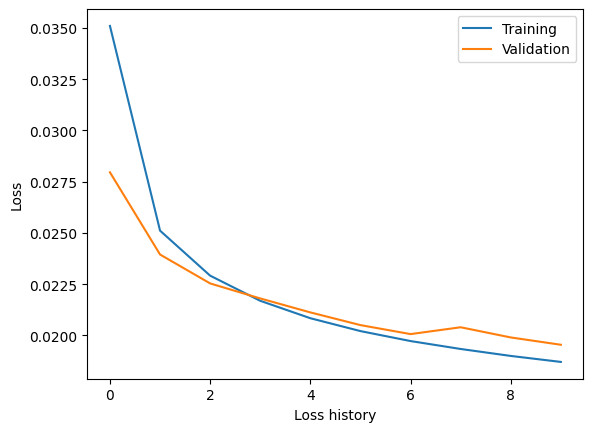

In [62]:
plot_history(history_denoise_mask_14.history)

In [63]:
reconstructed_ae_14 = CNNmnist_ae_denoise_mask_14(test_images_masked_14)

In [64]:
def plot_digits(X, title):
    """Small helper function to plot 100 digits."""
    fig, axs = plt.subplots(nrows=4, ncols=10, figsize=(8, 4))
    for img, ax in zip(X, axs.ravel()):
        ax.imshow(img.reshape((28, 28)), cmap="binary")
        ax.axis("off")
    fig.suptitle(title, fontsize=24)
    plt.show()

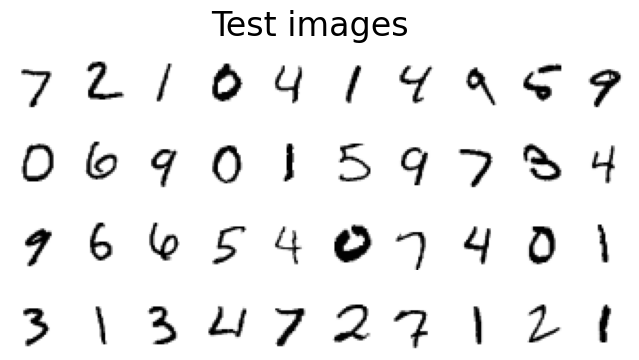

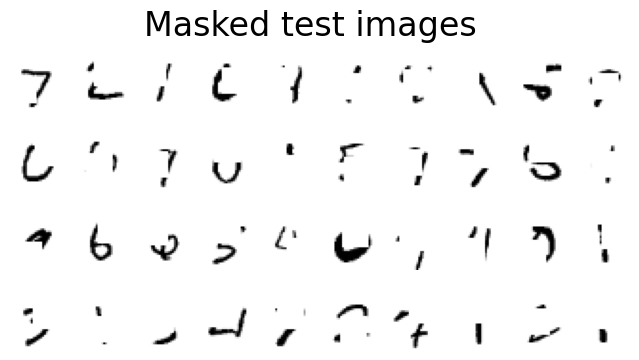

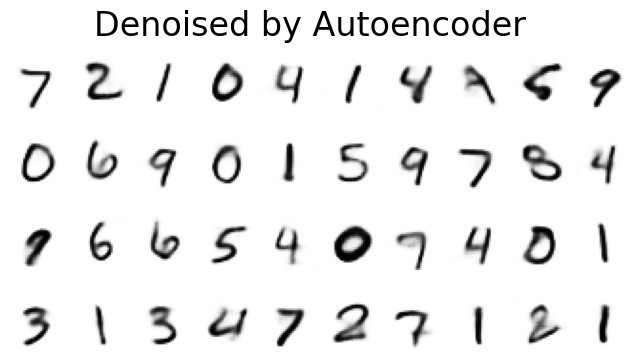

In [65]:
# Visualize the AE results
plot_digits(test_images, "Test images")
plot_digits(test_images_masked_14, "Masked test images")
plot_digits(reconstructed_ae_14.numpy(), "Denoised by Autoencoder")

### Masking 18x18 Pixels

In [ ]:
from sklearn.decomposition import PCA

# Add masking:
# - to training images
train_images_masked_18 = add_mask(train_images, 18)

# - to validation images
val_images_masked_18 = add_mask(val_images, 18)

# - to test images
test_images_masked_18 = add_mask(test_images, 18)

In [67]:
# Define Denoising Model
CNNmnist_encoder_denoise_mask_18 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (28, 28, 1)),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 14 × 14 x 16
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 7 × 7 x 32
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(30, activation='relu')
])

CNNmnist_decoder_denoise_mask_18 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(7*7*16, activation= 'relu'),
    tf.keras.layers.Reshape(target_shape = (7, 7, 16)),
    tf.keras.layers.Conv2D(32, kernel_size = (3,3), activation = 'selu', padding = 'same'),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2D(16, kernel_size = (3,3), activation = 'selu', padding = 'same'),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2D(1, kernel_size = (3,3), activation = 'sigmoid', padding = 'same'),
])

CNNmnist_ae_denoise_mask_18 = tf.keras.Sequential([CNNmnist_encoder_denoise_mask_18, CNNmnist_decoder_denoise_mask_18])
CNNmnist_ae_denoise_mask_18.compile(loss="mse", optimizer="nadam")

In [ ]:
# Define paths:
CNNmnist_encoder_denoise_mask_18_path = './CNNmnist_encoder_denoise_mask_18.weights.h5'
CNNmnist_decoder_denoise_mask_18_path = './CNNmnist_decoder_denoise_mask_18.weights.h5'
history_path = './CNNmnist_decoder_denoise_mask_18.history.h5'

if train_from_scratch:
    history_denoise_mask_18 = CNNmnist_ae_denoise_mask_18.fit(train_images_masked_18, train_images, epochs=nEpochs, validation_data=(val_images_masked_18, val_images),
                                                         callbacks = [ EarlyStopping(monitor='val_loss', patience=nPatience,
                                                                       verbose=False, restore_best_weights=True)])

    # Save the weights:
    CNNmnist_encoder_denoise_mask_18.save_weights(CNNmnist_encoder_denoise_mask_18_path)
    CNNmnist_decoder_denoise_mask_18.save_weights(CNNmnist_decoder_denoise_mask_18_path)

    # Save training history:
    with open(history_path, 'wb') as f:
        pickle.dump(history_denoise_mask_18, f)

else:
    # Load previsously computed weights
    CNNmnist_encoder_denoise_mask_18.load_weights(CNNmnist_encoder_denoise_mask_18_path)
    CNNmnist_decoder_denoise_mask_18.load_weights(CNNmnist_decoder_denoise_mask_18_path)

    # Load history:
    with open(history_path, 'rb') as f:
        history_denoise_mask_18 = pickle.load(f)

Epoch 1/10
1500/1500 [==============================] - 10s 5ms/step - loss: 0.0430 - val_loss: 0.0365
Epoch 2/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0354 - val_loss: 0.0345
Epoch 3/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0336 - val_loss: 0.0331
Epoch 4/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0325 - val_loss: 0.0323
Epoch 5/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0317 - val_loss: 0.0320
Epoch 6/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0311 - val_loss: 0.0315
Epoch 7/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0306 - val_loss: 0.0313
Epoch 8/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0302 - val_loss: 0.0308
Epoch 9/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0299 - val_loss: 0.0309
Epoch 10/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.02

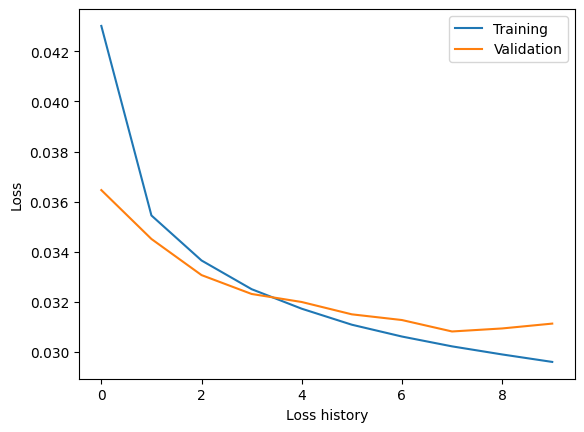

In [69]:
plot_history(history_denoise_mask_18.history)

In [70]:
reconstructed_ae_18 = CNNmnist_ae_denoise_mask_18(test_images_masked_18)

In [ ]:
def plot_digits(X, title):
    """Small helper function to plot 100 digits."""
    fig, axs = plt.subplots(nrows=4, ncols=10, figsize=(8, 4))
    for img, ax in zip(X, axs.ravel()):
        ax.imshow(img.reshape((28, 28)), cmap="binary")
        ax.axis("off")
    fig.suptitle(title, fontsize=24)
    plt.show()

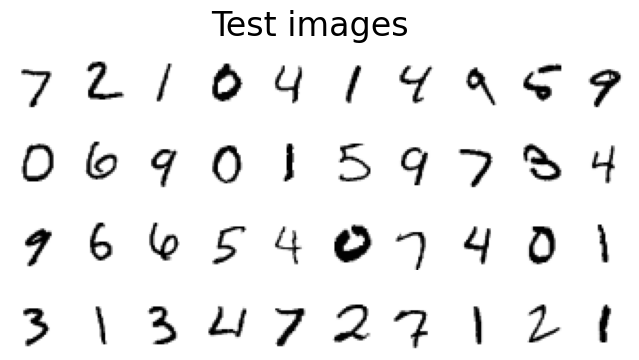

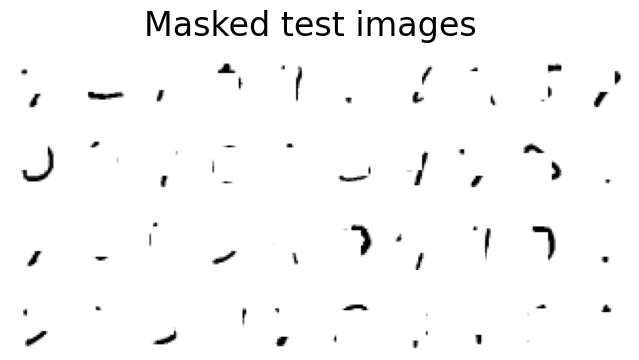

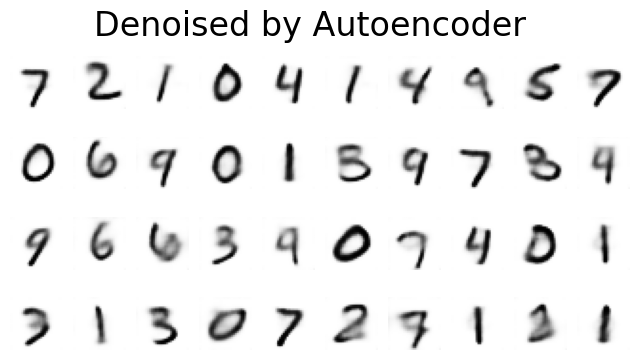

In [72]:
# Visualize the AE results
plot_digits(test_images, "Test images")
plot_digits(test_images_masked_18, "Masked test images")
plot_digits(reconstructed_ae_18.numpy(), "Denoised by Autoencoder")

Here, the reconstruction is quite blurry, but it still allows to reliably identify the digit.